# Содержание проекта

# Исследование объявлений о продаже квартир

Предоставлен архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет (данные сервиса Яндекс.Недвижимость). По каждой квартире на продажу доступны два вида данных:

- первые вписаны пользователем;
- вторые — получены автоматически на основе картографических данных (например, расстояние до центра, аэропорта, ближайшего парка и водоёма).

Необходимо научиться определять рыночную стоимость объектов недвижимости.

# Цель исследования
На основе исследовательского анализа данных установить параметры, влияющие на цену объектов недвижимости. Это позволит в дальнейшем построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
# Ход исследования

1. Обзор исходных данных (загрузка датасета, анализ общей информации, построение гистограмм для числовых данных).
2. Предобработка данных (работа с пропусками, выбросами и т.д.).
3. Добавление в таблицу новой информации (цена за 1 кв.м., разделение даты подачи объявления, тип этажа квартиры, расстояние до центра города);
4. Исследовательский анализ данных:
   
   4.1 исследование параметров на основе гистограмм
   
   4.2 исследование срока продажи квартиры
   
   4.3 определение факторов, влияющих на цену квартиры
   
   4.4 рассчет средней цены за 1 кв.м. в 10 населенных пунктах с наибольшим числом обьявлений
   
   4.5 рассчет цены на 1 км по удаленности от центра
   
5. Общий вывод


## Раздел 1. Обзор исходных данных

In [ ]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title Скрытая ячейка
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')

In [ ]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
# выведим основную информацию о датафрейме

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [ ]:
# приведем названия столбцов к корректным

data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 'parks_around3000': 'parks_around_3000', 'ponds_around3000': 'ponds_around_3000'})

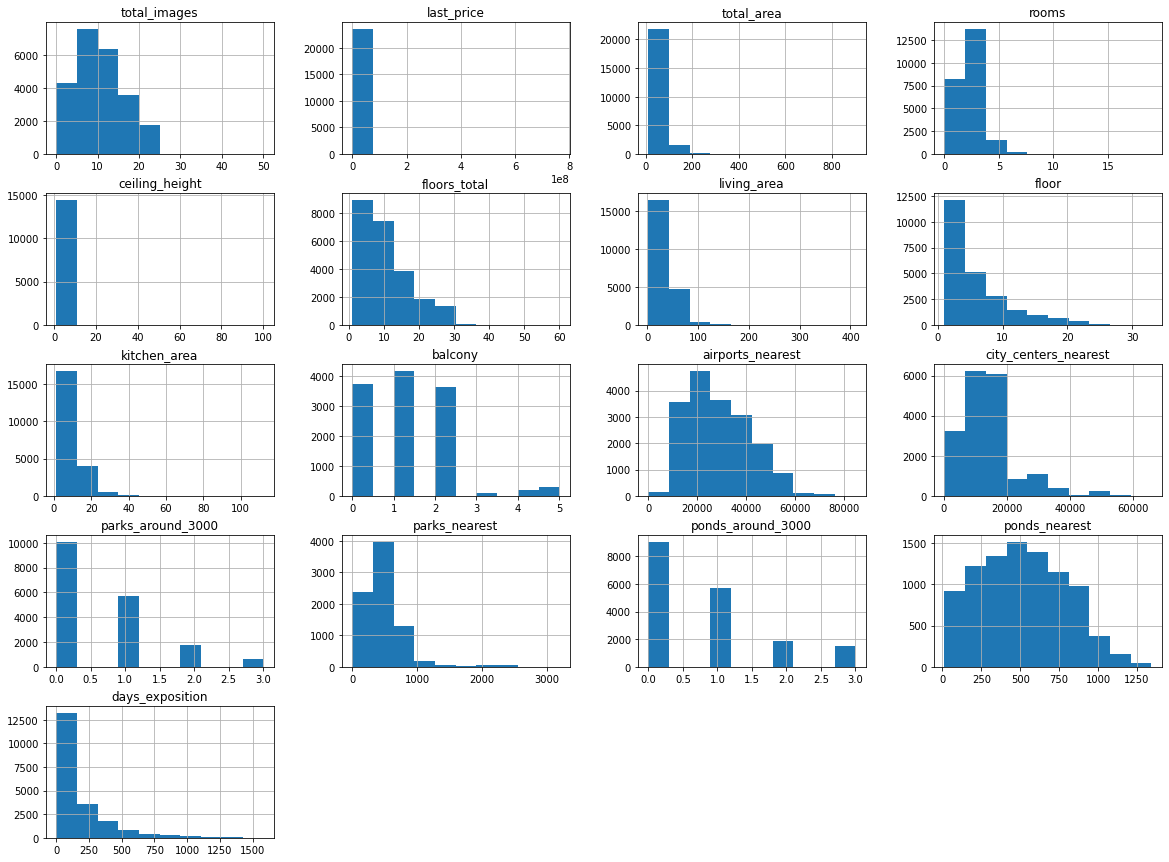

In [ ]:
# построим гистограммы для всех числовых данных из датафрейма

data.hist(figsize=(20, 15));

## Вывод по разделу 1.

Датафрейм содержит 22 столбца и 23699 строк. В ряде столбцов содержаться пропуски, некоторые столбцы имеют некорректный тип данных. Анализ гистограмм показывает, что ряд параметров имеет длинный "хвост", что может указывать на наличие выбросов. Также ряд параметров имеет нулевые значения или близкие к нему.

Таким образом, на этапе предобработки данных необходимо:
- изменить тип данных на корректный;
- поработать с пропусками и выбросами в данных;
- проанализировать корректность нулевых значений или близких к ним.

## Раздел 2. Предобработка данных

### 2.1 Работа с пропусками

In [ ]:
# подсчет пропусков в количестве значений и в %

missing_values = data.isna().sum()
missing_proc = (data.isna().mean()*100).round(1)

# результирующий DataFrame

missing_data = pd.DataFrame({'Пропуски в шт': missing_values,
                            'Пропуски в %': missing_proc}).style.background_gradient('coolwarm')
missing_data

,Пропуски в шт,Пропуски в %
total_images,0,0.000000
last_price,0,0.000000
total_area,0,0.000000
first_day_exposition,0,0.000000
rooms,0,0.000000
ceiling_height,9195,38.800000
floors_total,86,0.400000
living_area,1903,8.000000
floor,0,0.000000
is_apartment,20924,88.300000


**Причины пропусков и способы их заполнения.**

В нижеперечисленных столбцах пропуски могли возникнуть, если продавец не указал данную информацию (например, он ее не знает либо этого параметра нет в квартире (например, балкон)).

`ceiling_height` - высота потолков (м), заполним медианой, рассчитанной по всему датасету.

`floors_total` - всего этажей в доме, % пропусков достаточно мал, поэтому можно удалить строки с пропусками.

`living_area` — жилая площадь в квадратных метрах (м²), заполним медианой, рассчитаной в зависимости от количества комнат.

`is_apartment` — апартаменты (булев тип), будем предполагать, что пропуски означают, что объект не относится к аппартаментам, поэтому пропуски заменим на False.

`kitchen_area` — площадь кухни в квадратных метрах (м²), заполним медианой, рассчитаной в зависимости от количества комнат (учтем,что в студии площадь кухни отдельно не указывают, поэтому для студий оставим NaN).

`balcony` — число балконов, будем предполагать, что пропуски означают отсутствие балкона, поэтому заменим пропущенные значения на 0.

`locality_name` — название населённого пункта, % пропусков достаточно мал, поэтому можно удалить строки с пропусками.

Пропуски в указанных выше столбцах заполняем медианой, поскольку она не чувствительна к выбросам и данное заполнение существенного влияния на результат не окажет.

В нижеперечисленных столбцах пропуски могли возникнуть по техническим причинам, например, если поиск ближайшего аэропорта или парка и тд производят в определенном радиусе, при привышении которого в данных возникает пропуск:
- для столбцов `airports_nearest`, `city_сenters_nearest`,  `ponds_nearest` предложить логическую замену сложно, поэтому пропуски оставим как есть NaN;
- в столбцах `parks_around_3000` и `ponds_around_3000` одинаковое количество пропусков (составляет 23% от общего объема данных) возможно это взаимосвязано (для данных столбцов можно предположить, что пропуск означает отсутствие парка или водоема в радиусе 3 км и заполнить пропуски 0, но поскольку количество пропусков значимое, а данные столбцы по условию не учавствуют в исследовании оставим пропуски как NaN);
- в столбце `days_exposition` доля пропусков составляет 13% от общего объема данных, пропуски возникают по технической причине, которую желательно выяснить и устранить; сейчас пропуски заполним медианым значением, рассчитанным по всему датасету.


In [ ]:
# удалим строки, где отсутствует этажность ('floors_total') и название населенного пункта ('locality_name')

data = data.dropna(subset=['floors_total', 'locality_name'])

In [ ]:
# заполним пропуски в 'ceiling_height' медианой

data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [ ]:
# заполним пропуски в 'is_apartment'

data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

In [ ]:
# заполним пропуски в 'balcony'

data['balcony'] = data['balcony'].fillna(0)

In [ ]:
# заполним пропуски в 'living_area' и 'kitchen_area', учитывая количество комнат

for r in data['rooms'].unique():
    data.loc[(data['rooms'] == r) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == r), 'living_area'].median()

# 'kitchen_area' (для студий (r=0) площадь кухни оставим NaN)

    if r != 0:
        data.loc[(data['rooms'] == r) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
        data.loc[(data['rooms'] == r), 'kitchen_area'].median()


In [ ]:
# заполним пропуски в 'days_exposition' медианой

data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

In [ ]:
# проверим наличие пропусков в столбцах

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              194
balcony                     0
locality_name               0
airports_nearest         5524
city_centers_nearest     5501
parks_around_3000        5500
parks_nearest           15535
ponds_around_3000        5500
ponds_nearest           14529
days_exposition             0
dtype: int64

### 2.2 Работа с типами данных

In [ ]:
# изменение типов данных

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['last_price'] = data['last_price'].astype(int)
data['floors_total'] = data['floors_total'].astype(int)
data['is_apartment'] = data['is_apartment'].astype(bool)
data['balcony'] = data['balcony'].astype(int)
data['days_exposition'] = data['days_exposition'].astype(int)

### 2.3 Работа с дубликатами

In [ ]:
# определим уникальные значения в названиях населенных пунктов

data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Из очевидного: имеет буквы е и ё, которые могут дублировать названия, а также разное написание поселков: городской поселок, поселок городского типа и т.п.

In [ ]:
# заменим все ё на е

data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [ ]:
# заменим все названия поселков (ПГТ и тд) на поселок

data['locality_name'] = (data['locality_name'].str\
                         .replace('городской поселок', 'поселок').str
                         .replace('поселок городского типа', 'поселок').str
                         .replace('поселок станции', 'поселок').str
                         .replace('поселок при железнодорожной станции', 'поселок').str
                         .replace('коттеджный поселок', 'поселок'))

In [ ]:
# выведем неявные дубликаты в виде групп

dup = set() # сет для общих названий
for world in data['locality_name'].unique():
    name = world.split(' ')[-1] # разбиваем названия на отдельные слова и рассматриваем последнее
    if name != '' and not name in dup:
        dup.add(name)
        dup_final = data[data['locality_name'].str.contains(name)]['locality_name'].unique() # в dup_final записываем уникальные названия из 'locality_name', сгруппировав по name
        if len(dup_final)>1:
            print(dup_final)

['поселок Мурино' 'Мурино']
['деревня Кудрово' 'Кудрово']
['Коммунар' 'поселок Коммунары']
['поселок Красный Бор' 'Сосновый Бор' 'деревня Чудской Бор' 'деревня Бор'
 'деревня Трубников Бор' 'поселок Пансионат Зеленый Бор'
 'деревня Борисова Грива']
['деревня Федоровское' 'поселок Федоровское']
['садовое товарищество Новая Ропша' 'поселок Ропша']
['Кингисепп' 'поселок Кингисеппский']
['деревня Старая' 'поселок Старая Малукса' 'село Старая Ладога'
 'деревня Старая Пустошь']
['поселок Новый Свет' 'Светогорск']
['Никольское' 'село Никольское']
['поселок Романовка' 'деревня Малая Романовка']
['Луга' 'поселок Усть-Луга']
['село Павлово' 'поселок Павлово']
['поселок Большая Ижора' 'поселок Усть-Ижора']
['поселок Рахья' 'садовое товарищество Рахья']
['деревня Большие Колпаны' 'деревня Малые Колпаны']
['Новая Ладога' 'село Старая Ладога']
['поселок Зимитицы' 'деревня Зимитицы']
['деревня Бегуницы' 'деревня Старые Бегуницы']
['деревня Калитино' 'поселок Калитино']
['поселок Приладожский' 'садово

Имеем деревни и поселки, города и поселки, садовые товарищества и поселки с одноименным названием. Если посмотреть их локацию (использовала Википедию), то видно, что деревни входят в состав поселка и их можно объединить с поселком, тоже с остальными населенными пунктами.

In [ ]:
# Мурино, Кудрово, Любань приобрело статус города, запишем как город
data['locality_name'] = (data['locality_name'].str\
                         .replace('поселок Мурино', 'Мурино').str
                         .replace('деревня Кудрово', 'Кудрово').str
                         .replace('поселок Любань', 'Любань'))

# Федоровское, Зимитицы, Калитино, Щеглово, Рабитицы, Гарболово - это поселок (в состав которого входит деревня с тем же названием)
data['locality_name'] = (data['locality_name'].str\
                         .replace('деревня Федоровское', 'поселок Федоровское').str
                         .replace('деревня Зимитицы', 'поселок Зимитицы').str
                         .replace('деревня Калитино', 'поселок Калитино').str
                         .replace('деревня Щеглово', 'поселок Щеглово').str
                         .replace('деревня Рабитицы', 'поселок Рабитицы').str
                         .replace('деревня Гарболово', 'поселок Гарболово'))

# садовое товарищество Рахья, Новая Ропша и Приладожский запишем как поселок
data['locality_name'] = (data['locality_name'].str\
                         .replace('садовое товарищество Приладожский', 'поселок Приладожский').str
                         .replace('садовое товарищество Рахья', 'поселок Рахья').str
                         .replace('садовое товарищество Новая Ропша', 'поселок Ропша'))

Оставшиеся населенные пункты имеют разную локацию и соответственно не являются дубликатами.

In [ ]:
# найдем явные дубликаты

print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


### 2.4 Работа с аномальными значениями

Для анализа какие из данных отнести к выбросам можно воспользоваться диаграммой размаха, описанием таблицы с помощью .describe(). Выбросы можно определить с использованием межквартильного размаха (МКР) на основе следующего правила (из статистики):

- слабые выбросы - значения меньше (Q1-1,5*МКР) или больше (Q3+1,5*МКР)

- сильные выбросы - значения меньше (Q1-3*МКР) или больше (Q3+3*МКР)

Либо если выбросов много можно к выбросам отнести значения больше 98-о или 99-о процентиля или меньше 2-о и 1-о перцентиля.

Если выбросов до 10% ими можно пренебречь.

In [ ]:
# рассмотрим статистический анализ параметров

data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_images,23565.0,9.878421e+00,5.681156e+00,0.0,6.0,9.00,14.0,50.0
last_price,23565.0,6.540058e+06,1.091093e+07,12190.0,3400000.0,4646000.00,6790000.0,763000000.0
total_area,23565.0,6.032282e+01,3.565706e+01,12.0,40.0,52.00,69.7,900.0
rooms,23565.0,2.070656e+00,1.078591e+00,0.0,1.0,2.00,3.0,19.0
ceiling_height,23565.0,2.724530e+00,9.910260e-01,1.0,2.6,2.65,2.7,100.0
floors_total,23565.0,1.067588e+01,6.594823e+00,1.0,5.0,9.00,16.0,60.0
living_area,23565.0,3.432490e+01,2.172201e+01,2.0,18.4,30.30,42.7,409.7
floor,23565.0,5.878124e+00,4.871485e+00,1.0,2.0,4.00,8.0,33.0
kitchen_area,23371.0,1.045437e+01,5.665974e+00,1.3,7.3,9.00,11.5,112.0
balcony,23565.0,5.936771e-01,9.606601e-01,0.0,0.0,0.00,1.0,5.0


In [ ]:
# функция для построения диаграммы размаха

def diagram (param):
    data.plot(y=param, kind='box', grid=True, figsize = (8,2), title = 'Диаграмма размаха', vert=False)

Рассмотрим информацию по столбцам.
1. `last_price` — цена на момент снятия с публикации.

В столбце минимальная цена составляет 12190 тыс.руб., максимальная - 7.630000e+08.


1-й перцентиль: 1000000.0 , 99-й перцентиль: 36000000.0


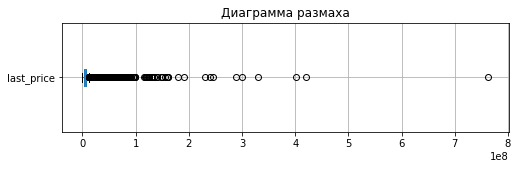

In [ ]:
# "ящик с усами"

diagram ('last_price')

# определим 1-й и 99-й перцентиль

q_99 = np.percentile (data['last_price'], 99)
q_1 = np.percentile (data['last_price'], 1)
print('')
print('1-й перцентиль:', q_1, ',', '99-й перцентиль:', q_99)

Boxplot показывает большое количество выбросов. Они могут относиться к элитной недвижимости и их желательно учесть (возможно даже рассматривать отдельно). Поэтому из анализа исключим только объекты недвижимости, которые встречаются редко - это меньше 1-о перцентиля и больше 99-о перцентиля.

In [ ]:
data = data[(data['last_price'] >= q_1) & (data['last_price'] <= q_99)]

2. `total_area` — общая площадь квартиры в квадратных метрах (м²)

In [ ]:
data['total_area'].describe()

count    23105.000000
mean        58.816982
std         29.483676
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        470.300000
Name: total_area, dtype: float64


99-й перцентиль: 170.0
1-й перцентиль: 25.3012


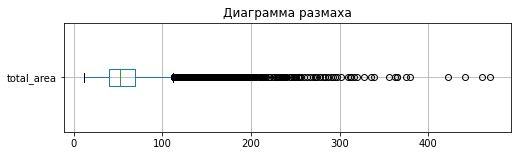

In [ ]:
# "ящик с усами"

diagram ('total_area')

# определим 1-й и 99-й персентиль

q_99 = np.percentile (data['total_area'], 99)
q_1 = np.percentile (data['total_area'], 1)
print('')
print('99-й перцентиль:', q_99)
print('1-й перцентиль:', q_1)

1. Минимальная площадь 12 кв.м., максимальная 470 кв.м. Смотрится как явные выбросы, удалим их.
2. Поскольку есть квартиры студии с очень маленькими площадями, то за нижний предел по площади возьмем 18 кв.м.
3. Верхний предел установим равный 99-у процентилю.

In [ ]:
data = data[(data['total_area'] >= 18) & (data['total_area'] <= q_99)]

3. `rooms` — количество комнат

count    22863.000000
mean         2.018327
std          0.971047
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64


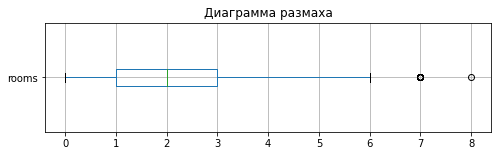

In [ ]:
print(data['rooms'].describe())

diagram ('rooms')

1. По boxplot к выбросам относим квартиры с 7-ю комнатами и более. Посмотрим сколько их.
2. Минимальное количество комнат - это 0. Скорее всего это студии, нужно посмотреть количество.

In [ ]:
print('Количество комнат больше 7:', data.query('rooms >= 7')['rooms'].count())
print('Нет комнат:', data.query('rooms == 0')['rooms'].count())

Количество комнат больше 7: 14
Нет комнат: 189


Количество квартир с 7-ю комнатами и более мало, ими можно пренебречь и исключить из анализа (возможно это элитная недвижимость и для оценки ее стоимости необходимо рассматривать отдельно). Квартиры без комнат оставим - это могут быть студии либо со свободной планировкой.

In [ ]:
data = data[data['rooms'] < 7]

4. `ceiling_height` - высота потолков.

Высота потолков стандартизированная величина для квартир изменяется в пределах от 2,5 до 3,2 м, иногда до 4 м в зависимости от года постройки.

count    22849.000000
mean         2.718206
std          1.002376
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


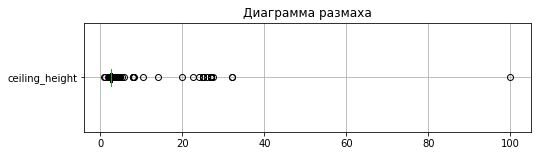

In [ ]:
print(data['ceiling_height'].describe())

diagram ('ceiling_height')

In [ ]:
# удалим явные выбросы - высота потолков 100 м

data = data[data['ceiling_height'] < 100]

Имеются квартиры с потолками от 20 до почти 40 м, это могут быть ошибки и на самом деле квартиры имеют высоту от 2 до 4 м.

In [ ]:
pd.options.mode.chained_assignment = None

# высоту потолков от 20 до 40 м будем считать за опечатку и заменим на диапазон от 2 до 4 м

data.loc[data['ceiling_height'] >=20, 'ceiling_height'] = data.loc[data['ceiling_height'] >=20, 'ceiling_height']/10

In [ ]:
q_99 = np.percentile (data['ceiling_height'], 99)
q_1 = np.percentile (data['ceiling_height'], 1)
print('')
print('99-й перцентиль:', q_99)
print('1-й перцентиль:', q_1)
print('Количество квартир с потолками ниже 2.5 м:', data.query('ceiling_height < 2.5')['ceiling_height'].count())
print('Количество квартир с потолками выше 3.5 м:', data.query('ceiling_height > 3.5')['ceiling_height'].count())
print('Количество квартир с потолками выше 4 м:', data.query('ceiling_height > 4')['ceiling_height'].count())


99-й перцентиль: 3.5
1-й перцентиль: 2.5
Количество квартир с потолками ниже 2.5 м: 76
Количество квартир с потолками выше 3.5 м: 216
Количество квартир с потолками выше 4 м: 36


In [ ]:
# удалим квартиры с потолками ниже 2.5 м и выше 4 м

data = data[(data['ceiling_height'] >= 2.5) & (data['ceiling_height'] <= 4)]

5. `floors_total` -количество этажей в доме.

count    22736.000000
mean        10.826707
std          6.616097
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


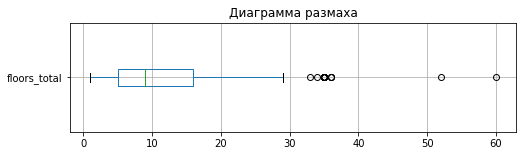

In [ ]:
print(data['floors_total'].describe())

diagram ('floors_total')

In [ ]:
# удалим явные выбросы (недвижимость в СПБ > 50 этажей относится только к бизнесс-центрам)

data = data[data['floors_total'] < 50]

# определим количество квартир в домах этажностью более 30

print('Дома более 30 этажей:', data.query('floors_total >= 30')['floors_total'].count())

Дома более 30 этажей: 29


In [ ]:
data = data[data['floors_total'] < 30]

6.  `living_area `— жилая площадь в квадратных метрах (м²).

count    22705.000000
mean        32.606481
std         16.014398
min          2.000000
25%         18.300000
50%         30.000000
75%         42.000000
max        140.000000
Name: living_area, dtype: float64


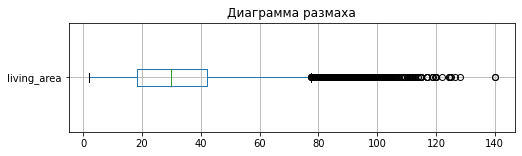

In [ ]:
print(data['living_area'].describe())
diagram ('living_area')

In [ ]:
q_99 = np.percentile (data['living_area'], 99)
q_1 = np.percentile (data['living_area'], 1)
print('')
print('99-й перцентиль:', q_99)
print('1-й перцентиль:', q_1)


99-й перцентиль: 88.2
1-й перцентиль: 13.1


Объекты, площадь которых лежит за пределами 1-о и 99-о процентиля исключим из анализа.

In [ ]:
data = data[(data['living_area'] >= q_1) & (data['living_area'] <= q_99)]

7. `floor `— этаж.

count    22254.000000
mean         5.917902
std          4.870908
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64


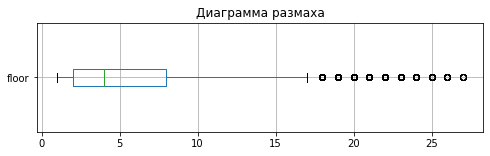

In [ ]:
print(data['floor'].describe())
diagram ('floor')

Необходимо проверить не превышает ли указанный в объявлении этаж общую этажность дома.

In [ ]:
print('Не правильных этажей:', (data['floor'] > data['floors_total']).sum())

Не правильных этажей: 0


8. `kitchen_area` - площадь кухни

count    22073.000000
mean        10.059203
std          4.664030
min          1.300000
25%          7.200000
50%          9.000000
75%         11.000000
max         65.000000
Name: kitchen_area, dtype: float64


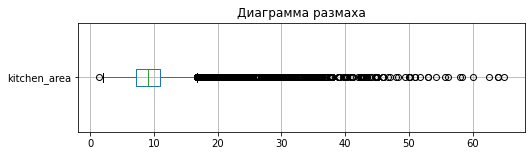

In [ ]:
print(data['kitchen_area'].describe())
diagram ('kitchen_area');

Кухня площадью 1.3 кв.м. можно посчитать за аномалию. Кухни с площадью более 30 кв.м. скорее всего это редкие значения. Рассмотрим их количество и примем решение относительно их.

In [ ]:
print('Кухня с минимальной площадью:', data.query('kitchen_area <= 1.3')['kitchen_area'].count())
print('Кухня площадью более 30 кв.м.:', data.query('kitchen_area > 30')['kitchen_area'].count())

Кухня с минимальной площадью: 1
Кухня площадью более 30 кв.м.: 193


In [ ]:
# учитывая пропуски в kitchen_area для удаления используем drop

data.drop(index=data.query('kitchen_area > 30').index,inplace=True)
data.drop(index=data.query('kitchen_area <= 1.3').index,inplace=True)

9. balcony - количество балконов

count    22060.000000
mean         0.600680
std          0.960657
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64


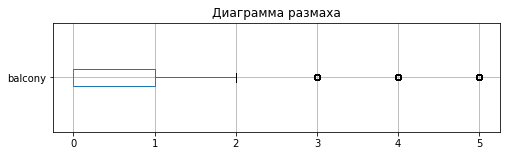

In [ ]:
print(data['balcony'].describe())
diagram ('balcony')

In [ ]:
# количество квартир с балконами более 3

print('Квартир с 3-я и более балконами:', data.query('balcony >= 3')['balcony'].count())
print('Квартир с 5-ю балконами:', data.query('balcony == 5')['balcony'].count())

Квартир с 3-я и более балконами: 515
Квартир с 5-ю балконами: 282


Оставим данные как есть, учитывая, что максимальное количество комнат 6, то балконов может быть 5.

10. `airports_nearest`

count    16886.000000
mean     28877.954222
std      12783.816025
min          0.000000
25%      18344.000000
50%      27024.000000
75%      37434.000000
max      84869.000000
Name: airports_nearest, dtype: float64


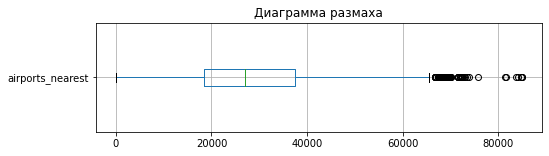

In [ ]:
print(data['airports_nearest'].describe())
diagram ('airports_nearest');

Есть квартиры с расстоянием до аэропорта равным 0, посмотрим их количество и удалим их.
По boxplot выбросы начинаются от 65000, посмотрим их количество.

In [ ]:
print('Квартир с расстоянием до аэропорта менее 500 м:', data.query('airports_nearest < 500')['airports_nearest'].count())
print('Квартир с расстоянием до аэропорта более 65000 м:', data.query('airports_nearest >= 65000')['airports_nearest'].count())

Квартир с расстоянием до аэропорта менее 500 м: 1
Квартир с расстоянием до аэропорта более 65000 м: 112


In [ ]:
# учитывая пропуски в airports_nearest для удаления используем drop

data.drop(index=data.query('airports_nearest < 500').index,inplace=True)
data.drop(index=data.query('airports_nearest > 65000').index,inplace=True)

11. `city_centers_nearest`

count    16793.000000
mean     14281.699577
std       8020.366160
min        208.000000
25%       9869.000000
50%      13252.000000
75%      16306.000000
max      61495.000000
Name: city_centers_nearest, dtype: float64


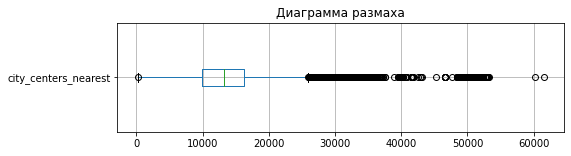

In [ ]:
print(data['city_centers_nearest'].describe())
diagram ('city_centers_nearest');

In [ ]:
print('Квартир с расстоянием до центра менее 500 м:', data.query('city_centers_nearest < 500')['city_centers_nearest'].count())
print('Квартир с расстоянием до центра более 40000 м:', data.query('city_centers_nearest >= 40000')['city_centers_nearest'].count())

Квартир с расстоянием до центра менее 500 м: 12
Квартир с расстоянием до центра более 40000 м: 178


In [ ]:
# учитывая пропуски в city_centers_nearest для удаления используем drop

data.drop(index=data.query('city_centers_nearest < 500').index,inplace=True)
data.drop(index=data.query('city_centers_nearest > 40000').index,inplace=True)

12. `parks_around_3000` и `ponds_nearest` -  не требуются для исследования

13. `parks_nearest`

count    7170.000000
mean      497.156067
std       340.990897
min         1.000000
25%       294.000000
50%       460.000000
75%       620.000000
max      3190.000000
Name: parks_nearest, dtype: float64


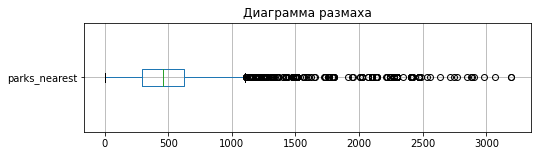

In [ ]:
print(data['parks_nearest'].describe())
diagram ('parks_nearest');

In [ ]:
print('Квартир с расстоянием до парка менее 20 м:', data.query('parks_nearest < 20')['parks_nearest'].count())
print('Квартир с расстоянием до парка более 1500 м:', data.query('parks_nearest >= 1500')['parks_nearest'].count())

Квартир с расстоянием до парка менее 20 м: 53
Квартир с расстоянием до парка более 1500 м: 151


In [ ]:
# учитывая пропуски в parks_nearest для удаления используем drop

data.drop(index=data.query('parks_nearest < 20').index,inplace=True)
data.drop(index=data.query('parks_nearest > 1500').index,inplace=True)

14. `days_exposition`

count    21553.000000
mean       165.467545
std        201.889316
min          1.000000
25%         45.000000
50%         95.000000
75%        193.000000
max       1580.000000
Name: days_exposition, dtype: float64


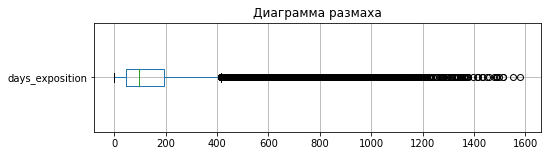

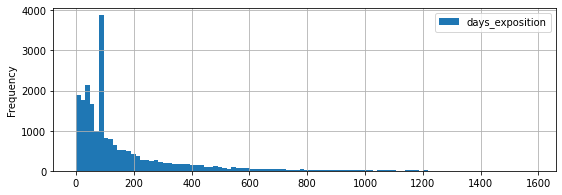

In [ ]:
print(data['days_exposition'].describe())

diagram ('days_exposition')
data.plot(y='days_exposition', kind='hist', bins=100, grid=True, figsize = (9,3));

In [ ]:
print('Объявления, размещенные меньше 3 дней:', data.query('days_exposition < 3')['days_exposition'].count())
print('Объявления, размещенные больше 1000 дней:', data.query('days_exposition >= 1000')['days_exposition'].count())

Объявления, размещенные меньше 3 дней: 4
Объявления, размещенные больше 1000 дней: 227


Объявлений, снятых с публикации раньше 3 дней, очень мало и ими можно принебречь. По boxplot к слабым выбросам можно отнести объявления, снятые с публикации через 400 дней, но их очень много, поэтому ограничимся 1000 днями. По гистограмме имеем очень большое количество объявлений, снятых через 90 дней, необходимо определить с чем это связано.

In [ ]:
# удалим редкие значения

data.drop(index=data.query('days_exposition < 3').index,inplace=True)
data.drop(index=data.query('days_exposition > 1000').index,inplace=True)

In [ ]:
# сброс индексации после удаления строк

data.reset_index(drop=True,inplace=True)

### Вывод по разделу 2

1. В датасете присутствует большое количество пропусков. В данных, которые заполняет продавец большинство пропусков можно заменить на характерные значения. В данных, которые заполняются автоматически на основе картографии также присутствует большое количество пропусков, причину которых желательно выявить и устранить, поскольку заполнить их сложно.
2. Для некоторых столбцов требовалось изменить тип данных, чтобы в дальнейшем используемые для анализа методы работали корректно. Также тип данных влияет на требуемый объем памяти.
3. Анализ датасета показал, что неявные дубликаты могут быть только в столбце `locality_name`. Следовательно, выполнена замена названий населенных пунктов и выполнен поиск дубликатов по всему датасету.
4. Графический анализ данных на основе boxplot и гистограмм показал большое количество значений, превышающих 1,5МКР. Эти данные нельзя сразу отнести к выбросам (т.к. они могут характеризовать особые группы недвижимости, например, элитную) и их необходимо учесть в анализе. Поэтому в большинстве случаев из данных исключались очень редкие значения. К редким значениям отнесли данные за пределами 1-о и 99-о процентиля. Также в данных присутствовали аномальные значения (например, высота потолков 25 и 32 м), которые исправлены на очевидные. В столбце `days_exposition` имеем странный выброс на значении 90, поскольку данные столбца автоматические необходимо выяснить, что происходит через 90 дней с объявлениями.
5. Удаленные данные (пропуски, дубликаты, аномалии и редкие значения) составили около 9,5% от исходного объема данных.

## Раздел 3. Добавление новых столбцов

#### Добавление столбца "Цена одного квадратного метра" - `price_sqm`.

Пропусков в столбцах `last_price` и `total_area` нет, но поскольку будем выполнять деление применим констукцию try...except.

In [ ]:
try:
    data['price_sqm'] = data['last_price'] / data['total_area']
    print('ok')
except:
    print('error')

ok


#### Добавление столбцов с датой публикации объявления:

- `day_announc` - "День недели публикации объявления (0 — понедельник, 1 — вторник и так далее)"
- `month_announc` - месяц публикации объявления
- `year_announc` - год публикации объявления

In [ ]:
data['year_announc'] = data['first_day_exposition'].dt.year

In [ ]:
data['day_announc'] = data['first_day_exposition'].dt.dayofweek

In [ ]:
data['month_announc'] = data['first_day_exposition'].dt.month

#### Добавление столбца "Тип этажа квартиры (значения — «первый», «последний», «другой»)" -  `floor_type`

In [ ]:
# создаем функцию, категоризирующую этаж (в функцию отправляем в качестве аргумента датасет)
def floor_type(row):
    if row['floor'] == 1:
        return('первый')
    elif row['floor'] == row['floors_total']:
        return('последний')
    else:
        return('другой')

# добавляем столбец с категорией этажа
data['floor_type'] = data.apply(floor_type, axis=1)

#### Добавление столбца `city_centers_nearest_km` - расстояние до центра города в километрах

In [ ]:
try:
    data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)
    print('ok')
except:
    print('error')

ok


## Раздел 4. Исследовательский анализ данных

#### 4.1 Проанализируем параметры объектов на основе гистограмм.

In [ ]:
# функция для построения гистограмм

def gistogramm (param, quan):
    data.plot(y=param, kind='hist', grid=True, figsize = (4,3), bins = quan, title = 'Гистограмма параметра ' +param)

1. `total_area` — общая площадь квартиры в квадратных метрах (м²)

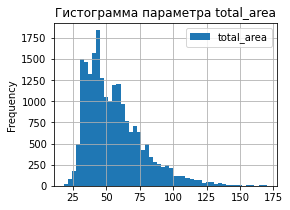

In [ ]:
gistogramm ('total_area', 50);

1. Анализ гистограммы показывает, что данные не симметричны и имеют длинный 'хвост' справа. Наиболее подходящее распределение для описания данных - распределение Пуассона.
2. Квартиры с площадью менее 25 кв.м. и более 120 кв.м. встречаются крайне редко, они также были видны на boxplot, как выбросы. В действительности таких квартир очень мало.
3. Больше всего объявлений с площадью от 42 до 45 кв.м. (частота объявлений более 1750), а также от 30 до 35 кв.м.(частота 1500) и от 55 до 60 кв.м. (частота около 1200). Данные категории возможно связаны с количеством комнат: 2-к, 1-к и 3-к.

2. `living_area` - жилая площадь

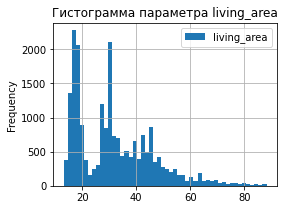

In [ ]:
gistogramm ('living_area', 50);

1. Наиболее редкие - это квартиры с жилой площадью более 65 кв.м.
2. В данном случае можно выделить следующие диапазоны - от 15 до 18 кв.м., от 25 до 30 кв.м., от 42 до 45 кв.м. Данные диапазоны согласуются с диапазонами параметра "общая площадь".

3. `kitchen_area` - площадь кухни

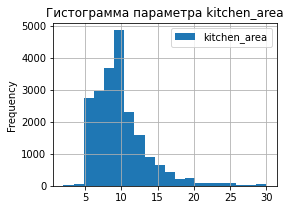

In [ ]:
gistogramm ('kitchen_area', 20);

1. Кухни с площадью меньше 5 кв.м. и больше 20 кв.м. можно посчитать за выбросы и стоило их удалить на шаге "Предобработка данных".
2. В остальном данные смотрятся адекватно.
3. Больше всего продается квартир с площадью кухни от 8 до 11 кв.м

4. `last_price` - цена объекта

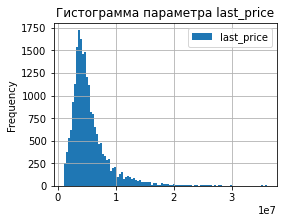

In [ ]:
gistogramm ('last_price', 100);

Анализ графика показывает наличие длинного правого "хвоста" - объявления с ценой более 15000000 достаточно редки.
Не учитывая цену более 10000000, данные симметричны и имеют моду около 4500 млн.руб.

5. `rooms` - количество комнат

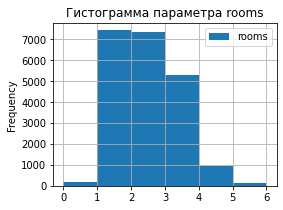

In [ ]:
gistogramm ('rooms', 6);

Вид графика ожидаем: больше всего продается 1-к и 2-к квартиры, немного меньше 3-к. Также имеются редкие значения: 0 - скорее всего это квартиры студии или со свободной планировкой, и квартиры с 4-я и 5-ю комнатами.

6. `ceiling_height` - высота потолков

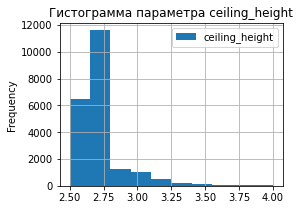

In [ ]:
gistogramm ('ceiling_height', 10);

Наблюдается пик в значении 2.7 м, а высота потолков более 3.2 м встречается редко.

7. `floor` - этаж квартиры

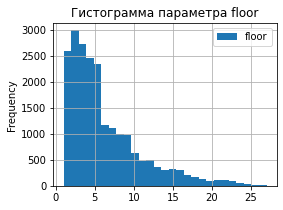

In [ ]:
gistogramm ('floor', 27);

Больше всего квартир расположены с 1 по 5 этаж, далее с 6 по 10. Редко когда квартиры расположены выше 20 этажа. Вполне логично, т.к. жилых домой этажностью больше 15 мало.

8. `floor_type` - тип этажа квартиры («первый», «последний», «другой»)

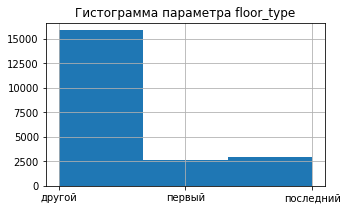

In [ ]:
plt.figure(figsize=(5,3))
data['floor_type'].hist(bins=3)
plt.title('Гистограмма параметра floor_type')
plt.show()

В целом квартир, расположенных на первом и последнем этажах, одинаково. Основное количество квартир расположено на других этажах.

9. `floors_total` - общее количество этажей в доме

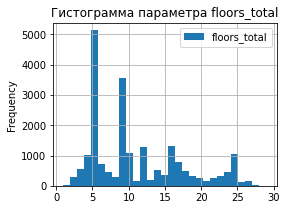

In [ ]:
gistogramm ('floors_total', 29);

Основные пики соответствуют 5-этажным (чуть более 5000 объявлений) и 9-этажным (около 3500 объявлений) домам. Три небольших пика соответствуют 12-этажным, 16-этажным и 24-этажным домам, их частота - порядка 1000-1200 объявлений.

10. `city_centers_nearest` - расстояние до центра города в метрах

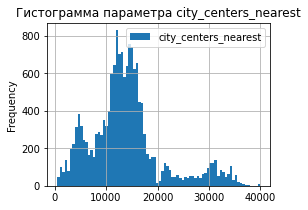

In [ ]:
gistogramm ('city_centers_nearest', 80);

Можно выделить три диапазона:
- от 1 км до 7 км с пиком 5 км.
- от 7 км до 20 км с пиком 12 км.
- от 20 км до 40 км с пиком 32 км.

11. `airports_nearest` - расстояние до ближайшего аэропорта

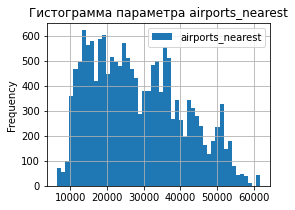

In [ ]:
gistogramm ('airports_nearest', 50);

Гистограмма смотрится немного зашумленной, поэтому ее сложно интерпретировать. Квартир, расположенных к аэропорту ближе чем 10 км и дальше 55 км, немного. В основном удаленность варьируется в диапазоне от 10 км до 45-50 км.

12. `parks_nearest` - расстояние до ближайшего парка

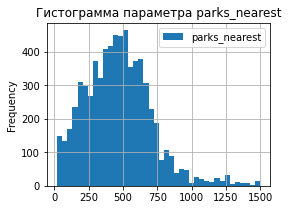

In [ ]:
gistogramm ('parks_nearest', 40);

Основная часть квартир удалена от парка на расстояние от 350 до 650 м. К редким объектам можно отнести квартиры, расположенные на расстоянии от 10 км от парка.

13. `day_announc` - день публикации объявления

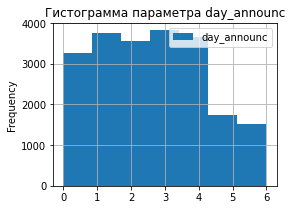

In [ ]:
gistogramm ('day_announc', 7);

В целом с понедельника по пятницу публикации объявлений распределены равномерно. Немного меньше объявлений публикуют в понедельник, больше во вторник и четверг. Очень заметно падает частота опубликования объявлений на выходных.

14. `day_month` - месяц публикации объявления

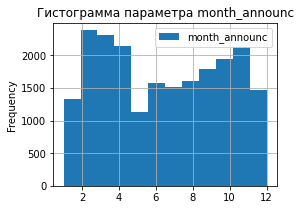

In [ ]:
gistogramm ('month_announc', 12);

Чаще на продажу выставляют квартиры с февраля по апрель и в ноябре. Активность публикаций падает в летние месяцы. Значительные провалы наблюдаются в мае, январе, и декабре. Данное распределение выглядит ожидаемо.

#### 4.2 Анализ срока продажи недвижимости

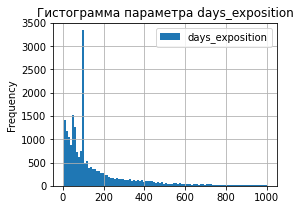

In [ ]:
gistogramm ('days_exposition', 100);

In [ ]:
print('Средний срок продажи квартиры:', data['days_exposition'].mean())
print('Медианный срок продажи квартиры:', data['days_exposition'].median())

Средний срок продажи квартиры: 154.9366910523354
Медианный срок продажи квартиры: 95.0


На гистограмме наблюдаем длинный "хвост" в правой части распределения. Среднее значение больше медианы, что говорит о нессиметричности распределения и наличии редких значений, выбросов, к которым медиана нечувствительна в отличие от среднего. Продажи более 200 дней достаточно редки, рассмотрим укрупненную гистограмму.

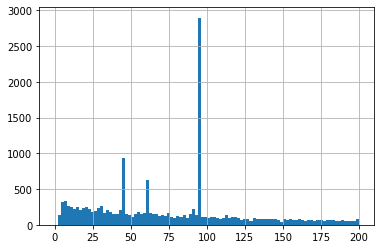

In [ ]:
data['days_exposition'].hist(bins=100, range=(0, 200))
plt.show()

Наблюдаем три пика, которые соответствуют 45, 60 и 90 дням, следовательно, в эти дни чаще всего объявления удаляют. Данный факт возможно связан с технической особенностью платформы. Необходимо выяснить причину, что происходит технически в эти дни.

In [ ]:
# для определения сроков продаж воспользуемся методом describe()

data['days_exposition'].describe()

count    21324.000000
mean       154.936691
std        174.136363
min          3.000000
25%         45.000000
50%         95.000000
75%        187.000000
max       1000.000000
Name: days_exposition, dtype: float64

Таким образом, за средний срок продажи недвижимости возмем 95 дней, продажи квартир до 45 дней можно отнести к быстрым продажам, продажи больше 187 дней - к долгим.

#### 4.3 Исследование факторов, влияющих на стоимость квартиры

Для выявления факторов влияющих на стоимость квартиры воспользуемся диаграммой рассеяния и коэффициентом корреляции. Для интерпретации значения коэффициента корреляции будем использовать шкалу Е.П. Голубкова.

In [ ]:
def diagram_cor(param_1, param_2):
  data.plot(x=param_1, y=param_2, kind='scatter', alpha=0.3, title = 'Диаграмма рассеяния', figsize = (5,3));

1. Влияние общей площади `total_area` на стоимость объекта `last_price`

Коэффициент корреляции:  0.7438406505702517


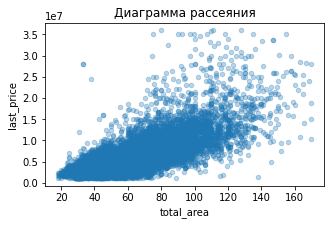

In [ ]:
# построим диаграмму рассеяния

diagram_cor('total_area', 'last_price')

# вычислим коэффициент корреляции
print('Коэффициент корреляции: ', data['total_area'].corr(data['last_price']))

Анализ диаграммы рассеяния показывает, что в центре имеем более типичные значения, по краям значения светлее характеризуют редкие значения, которые были выявлены на предыдущих этапах исследования.

Если убрать из рассматривыемых параметров редкие значения (например, ограничить `total_area` диапазоном от 20 до 120 кв.м., а в `last_price` рассматривать квартиры до 15 млн.руб.), то получим более "чистую" диаграмму рассеяния и скорее всего коэффициент корреляции вырастет.

В целом на графике наблюдается наличие положительной линейной зависимости, т.е. с ростом площади квартиры увеличивается ее стоимость. Коэффициент корреляции равен 0.74, что говорит о наличии умеренной статистической зависимости между параметрами и подтверждает результаты диаграммы рассеяния. Полученные результаты ожидаемы.

2. Влияние жилой площади `living_area` на стоимость объекта `last_price`

Коэффициент корреляции:  0.6017418839166866


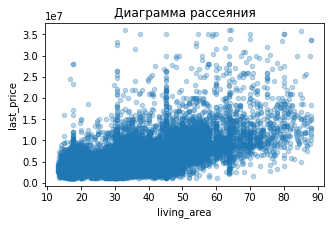

In [ ]:
# построим диаграмму рессеяния

diagram_cor('living_area', 'last_price')

# вычислим коэффициент корреляции
print('Коэффициент корреляции: ', data['living_area'].corr(data['last_price']))

Диаграмма рассеяния показывает более типичные значения в центре и наличие редких значений в данных по краям (более светлые точки).

Рассматривая типичные значения наблюдается положительная линейная зависимось между параметрами, однако, данную зависимость можно охарактеризовать, как слабую (коэффициент корреляции равен 0,6).

3. Влияние площади кухни `kitchen_area` на стоимость объекта `last_price`

Коэффициент корреляции:  0.5160906340122133


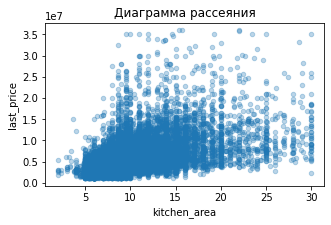

In [ ]:
# построим диаграмму рессеяния
diagram_cor('kitchen_area', 'last_price')

# вычислим коэффициент корреляции
print('Коэффициент корреляции: ', data['kitchen_area'].corr(data['last_price']))

Диаграмма рассеяния и коэффициент корреляции равный 0,52 показывают наличие слабой линейной зависимости между параметрами.

4. Влияние количества комнат `rooms` на стоимость объекта `last_price`

Сгруппируем данные по количеству комнат в pivot_table, в качестве aggfunc возьмем медиану (тк в данных имеются редкие значения, которые будут увеличивать среднее значение.

In [ ]:
rooms_pivot = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
rooms_pivot

,last_price
rooms,
0,2750000
1,3600000
2,4790000
3,6050000
4,7995000
5,9600000
6,9200000


Коэффициент корреляции:  0.44141837972557063


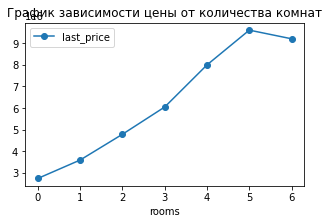

In [ ]:
# построим график зависимости параметров

rooms_pivot.reset_index().plot(x='rooms', y='last_price', kind='line', style='o-', title = 'График зависимости цены от количества комнат', figsize = (5,3))

# вычислим коэффициент корреляции
print('Коэффициент корреляции: ', data['rooms'].corr(data['last_price']))

Параметры показывают линейную зависимость, но она статистически слабая, так как коэффициент корреляции 0.44.

5. Влияние этажа, на котором расположена квартира (первый, последний, другой) `floor_type` на стоимость объекта `last_price`

Сгруппируем данные по типу этажа в pivot_table, в качестве aggfunc возьмем медиану.

In [ ]:
floor_type_pivot = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
floor_type_pivot

,last_price
floor_type,
другой,4750000
первый,3940000
последний,4230000


0.08430504778539942


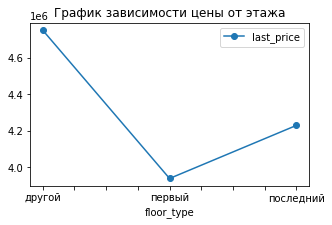

In [ ]:
# построим график зависимости параметров

floor_type_pivot.reset_index().plot(x='floor_type', y='last_price', kind='line', style='o-', title = 'График зависимости цены от этажа', figsize = (5,3))

# вычислим коэффициент корреляции
print(data['floor'].corr(data['last_price']))

По графику можно сказать, что квартиры, расположенные на первом этаже самые недороги, немного дороже квартиры, расположенные на последнем этаже. Самые дорогие квартиры, расположенные на этажах, отличных от первого и последнего.  

6. Влияние даты размещения (день недели - `day_announc`, месяц - `month_announc`, год - `year_announc`) на стоимость объекта `last_price`

In [ ]:
day_pivot = data.pivot_table(index='day_announc', values='last_price', aggfunc='median')

-0.006647899274507191


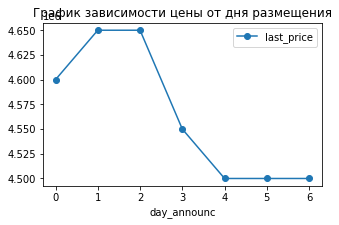

In [ ]:
# построим график зависимости параметров
day_pivot.reset_index().plot(x='day_announc', y='last_price', kind='line', style='o-', title = 'График зависимости цены от дня размещения', figsize = (5,3))

# вычислим коэффициент корреляции
print(data['day_announc'].corr(data['last_price']))

In [ ]:
month_pivot = data.pivot_table(index='month_announc', values='last_price', aggfunc='median')

0.0028467873560877274


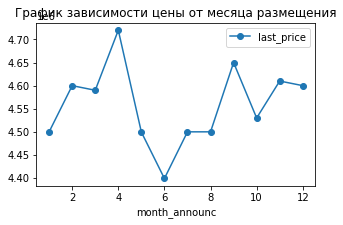

In [ ]:
# построим график зависимости параметров
month_pivot.reset_index().plot(x='month_announc', y='last_price', kind='line', style='o-', title = 'График зависимости цены от месяца размещения', figsize = (5,3))

# вычислим коэффициент корреляции
print(data['month_announc'].corr(data['last_price']))

In [ ]:
year_pivot = data.pivot_table(index='year_announc', values='last_price', aggfunc='median')

-0.004206663539981726


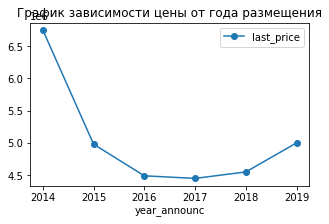

In [ ]:
# построим график зависимости параметров
year_pivot.reset_index().plot(x='year_announc', y='last_price', kind='line', style='o-', title = 'График зависимости цены от года размещения', figsize = (5,3))

# вычислим коэффициент корреляции
print(data['year_announc'].corr(data['last_price']))

Рассмотрим динамику площади продаваемых квартир по годам.

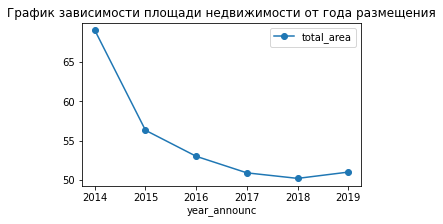

In [ ]:
area_pivot = data.pivot_table(index='year_announc', values='total_area', aggfunc='median')
area_pivot.reset_index().plot(x='year_announc', y='total_area', kind='line', style='o-', title = 'График зависимости площади недвижимости от года размещения', figsize = (5,3))
plt.show()

Анализ коэффициентов корреляции говорит об отсутствии существенной линейной связи между исследуемыми параметрами. Анализ графиков показывает:
- квартиры, опубликованные в апреле, имеют самую высокую стоимость, а в июне - самую низкую; в данном случае необходимо учитывать специфику региона, тк действительно в некоторых регионах продажи и в частности цена на квартиры в летние месяцы падает (возможно, стоит посмотреть как меняется площадь, продаваемых квартир по месяцам).
- учитывая статистическую зависимость между площадью квартиры и ее стоимостью, можно сказать, что начавшееся в 2014 г. уменьшением стоимости обусловлено уменьшение площади продаваемых объектов.


#### 4.4 Рассчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [ ]:
sqm_max_10 = data.groupby('locality_name').agg({'price_sqm':'mean', 'last_price': 'count'}) \
                 .sort_values(by = 'last_price', ascending = False) \
                 .head(10)
sqm_max_10.columns = ['Средняя цена за 1 кв.м','Количество объявлений']
sqm_max_10

,Средняя цена за 1 кв.м,Количество объявлений
locality_name,,
Санкт-Петербург,110028.632000,14199
Мурино,85971.750664,568
Кудрово,95348.368740,453
поселок Шушары,78034.830783,421
Всеволожск,68732.829919,386
Пушкин,102830.764573,341
Колпино,75233.468450,327
поселок Парголово,89887.811048,310
Гатчина,68918.185751,304


Наибольшее количество объявления опубликовано по Санкт-Петербургу, а также в близлежайших к нему населенных пунктах. Самые дорогой кв.м. соответствует Санкт-Петербургу.

#### 4.5 Рассчет средней цены каждого км по Санкт-Петербургу с учетом расстояния до центра

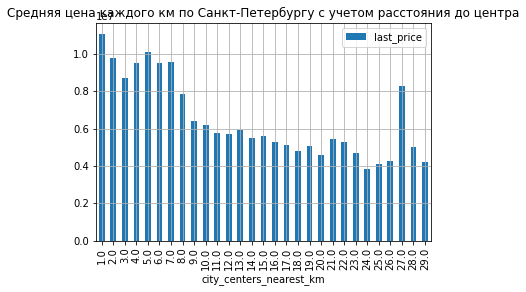

In [ ]:
# формируем сводную таблицу по Санкт-Петербургу и строим график
(
    data[data['locality_name']=='Санкт-Петербург']
    .pivot_table(
        index='city_centers_nearest_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar', grid=True, title = 'Средняя цена каждого км по Санкт-Петербургу с учетом расстояния до центра')
);

Как и ожидалось самые дороги квартиры расположены ближе к центру, а именно до 9 км. Пик на 27 км смотрится странно, его природу сложно объяснить, может быть это выброс либо необходимо выяснить, что за район расположет в 27 км от центра города.

### Общий вывод

1. В датасете присутствует большое количество пропусков. Часть пропусков была заменена на медианные значения. В данных, которые заполняются автоматически необходимо выявить причину пропусков для ее устранения. Ряд параметров имеет редкие значения или выбросы, в целом по датасету это значимое количество.  Поэтому в большинстве случаев из данных исключались данные за пределами 1-о и 99-о процентиля. Всего из датасета было удалено 9,5% данных.

2. Рассматривая характеристики квартир, можно отметить:

- самый распространенный диапазон для общей площади - от 30 до 60 кв.м., для жилой – от 15 до 45 кв.м., для площади кухни – от 8 до 11 кв.м.;
- самая распространенная высота потолков – 2.7 м.
- больше всего продается 1-к и 2-к квартиры, немного меньше 3-к, также имеются 4-х и 5-и комнатные квартиры, но они редки.
- основная часть квартир расположена с 1 по 5 этаж, далее с 6 по 10, этажи выше – это уже более редкие значения; при этом количество квартир на первом и последнем этаже практически одинаково, а основная часть квартир расположена на других этажах.
- стоимость квартир варьируется в диапазоне от 1 до 36 млн.руб., при этом самая распространенная цена (мода) 4500 млн.руб. (учитывая, что больше всего продается 1-х квартир данная цена вполне логична), а квартиры стоимостью от 15 млн.руб. крайне редки.

Рассматривая характеристики дома, где расположен объект недвижимости можно отметить:
- самые распространенные дома – пятиэтажные и девятиэтажные.
- большая часть квартир удалена от центра на расстояние от 7 до 20 км, из них основная часть квартир расположена в 12 км от центра; меньше квартир, расположенных близко к центру – от 1 до 7 км и редкое количество квартир, расположенных достаточно далеко – от 20 до 40 км.
- основная часть квартир удалена от аэропорта на расстояние от 10 до 50 км, от парка на расстояние от 350 до 650 м.

Рассматривая характеристики объявления, можно отметить:
- частота опубликования объявлений в будние дни в целом распределена равномерно (в понедельник чуть меньше, во вторник и четверг немного больше) и заметно падает на выходных;
- частота опубликования объявлений выше с февраля по апрель и в ноябре, в летние месяцы наблюдается уменьшение, а значительные провалы - в мае, январе, и декабре.
      
3. Анализ данных показал, что:

- средний срок продажи квартир составляет 95 дней,
- продажи квартир до 45 дней можно отнести к быстрым продажам,
- продажи больше 187 дней - к долгим.

Стоит отметить, что большое количество объявлений снято с публикаций на 45-й, 60-й и 90-й день. Необходимо выяснить причину этого факта, возможно это технический сбой и нужно обработать эти данные как аномальные.

4. Исследование факторов, влияющих на стоимость квартиры, показало:

- сильнее всего стоимость квартиры зависит от площади квартиры (общей площади, далее жилая площадь, площадь кухни) и количества комнат;
- между стоимостью квартиры и ее этажом, а также между стоимостью квартиры и датой публикации объявления линейной связи не выявлено, при этом:
	- квартиры, расположенные на первом этаже имеют самую низкую стоимость, немного дороже квартиры, расположенные на последнем этаже, а самые дорогие квартиры, расположенные на этажах, отличных от первого и последнего;
  - площадь продаваемых квартир начала уменьшаться с 2014 г., что привело к уменьшению стоимость квартир по годам.

5. Наибольшее количество объявлений опубликовано по Санкт-Петербургу, а также в близлежайших к нему населенных пунктах. Самые дорогой кв.м. соответствует Санкт-Петербургу. Самые дороги квартиры расположены ближе к центру, а именно до 9 км. Также высокая цена наблюдается для объектов недвижимости, удаленных на 27 км от центра.
6. Анализ проводился по всему архиву объявлений без категоризации объектов недвижимости. Возможно, разделение квартир на категории (например, эконом- класс, комфорт-класс, бизнес-класс) даст более точную оценку параметров, влияющих на их стоимость.